In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr, gaussian_kde


In [ ]:
df = pd.read_csv("../data/dbscan_clusterability.csv")

In [27]:
df = df.drop_duplicates(subset="category")

In [28]:
df["perc_big_clusters"] = df["n_big_clusters"] / df["tot_n_clusters"]

In [29]:
df["perc_small_clusters"] = 1-df["perc_big_clusters"]

In [30]:
df["n_big_clusters"].describe()

count    344.000000
mean       3.578488
std        2.317308
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       22.000000
Name: n_big_clusters, dtype: float64

## Focus on % noise

In [31]:
df.sort_values("perc_noise", ascending=True, inplace=True)

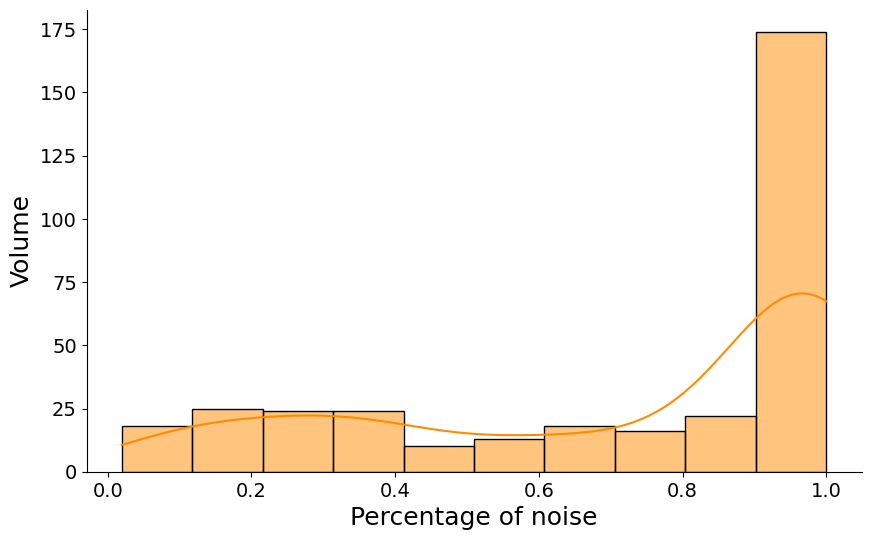

In [32]:
# get desnity distribution of perc_noise, with histogram and kernel density estimate
plt.figure(figsize=(10,6))
sns.histplot(df['perc_noise'], bins=10, kde=True, color='darkorange')
plt.xlabel('Percentage of noise', fontsize=18)
plt.ylabel('Volume', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()
# save as pdf
plt.savefig("../plots_downstream/perc_noise_distribution.pdf", bbox_inches='tight')

Find local minimum between the two modes

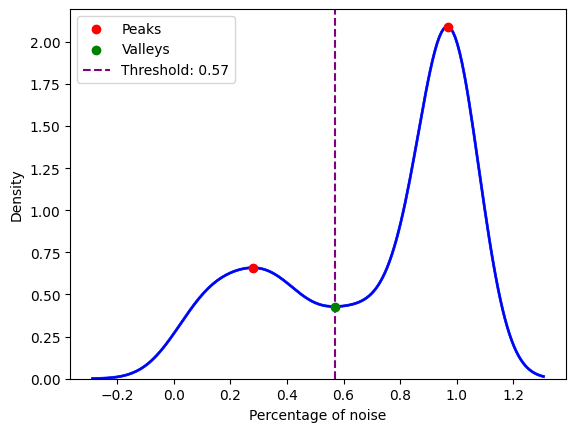

0.5698004492020455

In [11]:
perc_noise = df["perc_noise"]   

# KDE plot
sns.kdeplot(perc_noise, color="blue", linewidth=2)
plt.xlabel("Percentage of noise")
plt.ylabel("Density")

# Fit KDE using seaborn's default bandwidth
kde = sns.kdeplot(perc_noise).get_lines()[0].get_data()
x_vals, y_vals = kde[0], kde[1]

# Find local maxima and minima
peaks, _ = scipy.signal.find_peaks(y_vals)
valleys, _ = scipy.signal.find_peaks(-y_vals)  # Minima

# Identify the first valley after the first peak
if len(peaks) > 1 and len(valleys) > 0:
    first_valley = valleys[0]
    threshold = x_vals[first_valley]
else:
    threshold = None  # No clear separation

# Plot results
plt.plot(x_vals, y_vals, color="blue")
plt.scatter(x_vals[peaks], y_vals[peaks], color="red", label="Peaks", zorder=3)
plt.scatter(x_vals[valleys], y_vals[valleys], color="green", label="Valleys", zorder=3)
if threshold:
    plt.axvline(threshold, color="purple", linestyle="--", label=f"Threshold: {threshold:.2f}")
plt.legend()
plt.show()

# Output the computed threshold
threshold

### Focus on clusterable categories

In [33]:
categories_clusterable = df[perc_noise < threshold]

In [ ]:
list_categories = categories_clusterable["category"].tolist()

In [35]:
df_clusterable = categories_clusterable[["category"]]
df_clusterable.to_csv("../data/categories_clusterable.csv", index=False)


In [36]:
categories_nonclusterable = df[perc_noise >= threshold]

In [37]:
df_nonclusterable = categories_nonclusterable[["category"]]
df_nonclusterable.to_csv("../data/categories_nonclusterable.csv", index=False)


### Correlation with concreteness and sensorimotor

Add sensorimotor data for categories

In [38]:
sensorimotor = pd.read_csv("../data/sensorimotor_categories.csv")

Add concreteness scores

In [39]:
concreteness = pd.read_csv("../data/concreteness_categories.csv")

In [40]:
df_merge = df.merge(sensorimotor, on="category")
df_merge = df_merge.merge(concreteness, on="category")

In [41]:
# correlation matrix
var_corr = ['Auditory.mean', 'Gustatory.mean', 'Haptic.mean',
            'Interoceptive.mean', 'Olfactory.mean', 'Visual.mean', 'Foot_leg.mean',
            'Hand_arm.mean', 'Head.mean', 'Mouth.mean', 'Torso.mean', 'concreteness']
bonferroni = 0.05 / len(var_corr)
print(f"Bonferroni corrected p-value: {bonferroni}")

for var in var_corr:
        corr, pvalue = spearmanr(df_merge["perc_noise"], df_merge[var])

        if pvalue < bonferroni:
                print(f"{var}: {corr:.2f} ({pvalue:.2e}) *")
        else:
                print(var, corr, "Non significant")


Bonferroni corrected p-value: 0.004166666666666667
Auditory.mean 0.12365380803335806 Non significant
Gustatory.mean -0.04158169015276339 Non significant
Haptic.mean: -0.24 (6.55e-06) *
Interoceptive.mean -0.02409699954873006 Non significant
Olfactory.mean 0.06889710261654432 Non significant
Visual.mean -0.02185464908030915 Non significant
Foot_leg.mean -0.015450263739373468 Non significant
Hand_arm.mean: -0.19 (5.22e-04) *
Head.mean 0.05505463727600399 Non significant
Mouth.mean -0.012652582398274137 Non significant
Torso.mean 0.02081405169143809 Non significant
concreteness -0.05755283195116935 Non significant


In [42]:
df_merge["clusterability"] = 1-df_merge["perc_noise"]

0.2797202797202798 0.37856866966230307


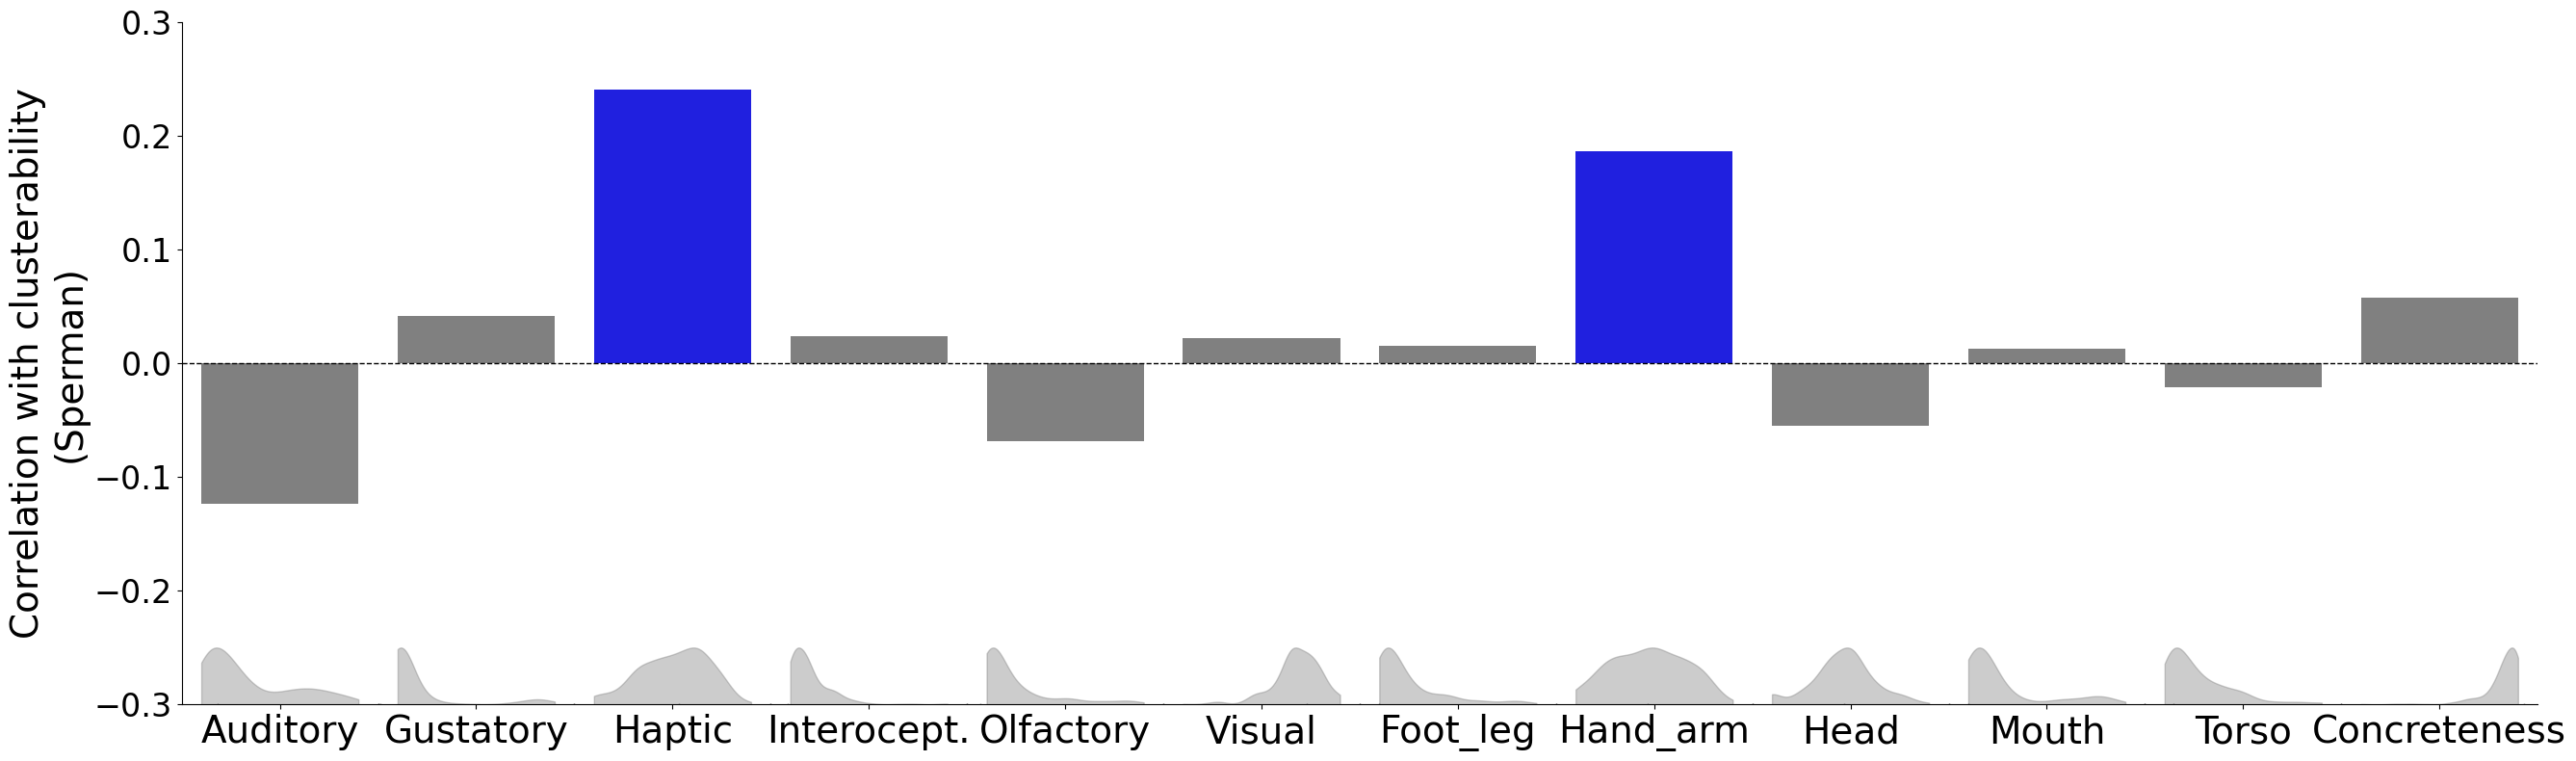

In [45]:
# --- compute correlations ---
correlations = []
mean_values = []
pvalues = []
for var in var_corr:
    corr, pvalue = spearmanr(df_merge["clusterability"], df_merge[var])
    correlations.append(corr)
    pvalues.append(pvalue)
    mean_val = np.mean(df_merge[var].dropna().values)
    mean_values.append(mean_val)

corr_meta, pvalue_meta = spearmanr(correlations, mean_values)
print(corr_meta, pvalue_meta) #non-significant

colors = ['red' if p < bonferroni and corr < 0 else 
          'blue' if p < bonferroni and corr > 0 else 
          'gray' for corr, p in zip(correlations, pvalues)]

# --- main bar plot ---
fig, ax = plt.subplots(figsize=(27,8))
sns.barplot(x=var_corr, y=correlations, palette=colors, width=0.8, ax=ax)

# horizontal line at 0
ax.axhline(0, color="black", linestyle="dashed", linewidth=1)

# --- add tiny horizontal KDE bumps centered at each tick ---
for i, var in enumerate(var_corr):
    values = df_merge[var].dropna().values
    if len(values) < 5:
        continue

    # KDE
    kde = gaussian_kde(values)
    xs = np.linspace(np.min(values), np.max(values), 200)
    ys = kde(xs)

    # normalize KDE height → max width of bump
    ys = ys / ys.max() * 0.05
    offset = -0.3

    # scale xs to the full width of the bar (width=0.8)
    bar_width = 0.8
    xs_scaled = (xs - xs.min()) / (xs.max() - xs.min()) * bar_width + (i - bar_width/2)

    # fill the bump
    ax.fill_between(xs_scaled, offset, ys + offset, alpha=0.4, color="gray")

    # add mini ticks for min, median, max values
    tick_positions = [np.min(values), np.median(values), np.max(values)]
    tick_positions_scaled = (np.array(tick_positions) - np.min(values)) / (np.max(values) - np.min(values)) - 0.5 + i
    for tp in tick_positions_scaled:
        ax.plot([tp, tp], [offset, offset - 0.02], color="black", lw=1)  # 0.02 = tick length

# --- formatting ---
labels = ['Auditory', 'Gustatory', 'Haptic', 'Interocept.', 'Olfactory', 
          'Visual', 'Foot_leg', 'Hand_arm', 'Head', 'Mouth', 'Torso', 'Concreteness']
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=28)
ax.set_ylabel("Correlation with clusterability\n(Sperman)", fontsize=28)
ax.set_ylim(-0.3, 0.3)
ax.tick_params(axis="y", labelsize=24)

ax.set_xlim(-0.5, len(var_corr)-0.5)
sns.despine()
plt.tight_layout()
plt.savefig("../plots_downstream/correlation_properties.pdf", bbox_inches='tight')
